# Proyecto  ML  for engineering - Grupo 1 

## Integrantes
- Juan Camilo Rojas Hernández ()
- Sergio Andres Canar Lozano ()
- Wilman Sanchez Hernandez (`)

#### Imports

In [1]:
import os 
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import CelebFacesDataset
from model import ResNet, ResidualBlock, get_resnet101_model, get_resnet18_model,  get_vgg16_model

#### CUDA Settings

In [2]:
use_cuda = True
torch.cuda.manual_seed(42)
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")   
print(device) 

cuda


#### Paths

In [3]:
this_dir = os.getcwd()
data_dir = os.path.join(this_dir, 'data')
img_dir = os.path.join(data_dir, 'face_recognition', 'Faces')
data_path = os.path.join(data_dir, 'face_recognition', 'dataset_faces.csv')

#### Create Datasets and Dataloaders

In [4]:
# Dataset 
# Define the set of transformations to be applied to the images
transforms_set = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.6389, 0.4773, 0.4056], std=[0.2343, 0.1996, 0.1831]),  # Normalize images
])

# Load the dataset from a CSV file
data = pd.read_csv(data_path)

# Create a dataset object with the loaded data and transformations
dataset = CelebFacesDataset(df=data, root_dir=img_dir, transform=transforms_set)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
_, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define the number of classes in the dataset
num_classes = 31

# Load the pre-trained ResNet18 model with the specified number of classes
model = get_resnet18_model(num_classes=num_classes)
# model = get_resnet101_model(num_classes=num_classes)
# model = get_vgg16_model(num_classes=num_classes)
# model = ResNet(ResidualBlock, [3, 4, 6, 3, 2], num_classes=num_classes)

In [5]:
epsilons = [0, 0.0001, 0.001, 0.005, 0.007, 0.01, 0.1, 0.3, 0.5, 1]
pretrained_model = 'models/resnet18_celeb_faces.pth'
model.load_state_dict(torch.load(pretrained_model, map_location=device, weights_only=True))

print('Model loaded!')
print(len(epsilons))

Model loaded!
10


# FGSM Attack


$$perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))$$

In [6]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


def denormalize(batch, mean=[0.6389, 0.4773, 0.4056], std=[0.2343, 0.1996, 0.1831]):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device=device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device=device)
    return batch * std.view(1, 3, 1, 1) + mean.view(1, 3, 1, 1)

def normalize(batch, mean=[0.6389, 0.4773, 0.4056], std=[0.2343, 0.1996, 0.1831]):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device=device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device=device)
    return (batch - mean.view(1, 3, 1, 1)) / std.view(1, 3, 1, 1)

#### Test function

In [7]:
def test_with_FGSM(model, test_loader, epsilon):
    '''
    Test the model with the FGSM attack on the test dataset
    -----------------------------------------
    Parameters:
    - model: the model to be tested
    - test_loader: the DataLoader of the test dataset
    - epsilon: the perturbation factor
    -----------------------------------------
    Returns:
    - the accuracy of the model on the test dataset with the FGSM attack
    - the perturbed images
    
    '''
    # Accuracy counter
    correct = 0
    adv_examples = []
    
    # Set the model in evaluation mode
    model.eval()
    
    # Loop over all examples in the test dataset
    with tqdm(total=len(test_loader), desc=f'FGSM Attack with Epsilon = {epsilon}') as pbar:
        for data, target in test_loader:
            
            data, target = data.to(device), target.to(device) # Move the data to the device
            data.requires_grad = True
            
            # Forward pass the data through the model
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1] # Get the index of the max log-probability
            
            # If the initial prediction is wrong, do not bother attacking, just move on
            if init_pred.item() != target.item():
                continue
            
            # Calculate the loss
            loss = F.nll_loss(output, target)
            
            # Zero all existing gradients
            model.zero_grad()
            
            # Calculate gradients of model in backward pass
            loss.backward()
            
            # Collect the gradients of the data
            data_grad = data.grad.data
            
            data_denorm = denormalize(data)
            
            # Call FGSM Attack
            perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
            
            perturbed_norm = normalize(perturbed_data)
            
            # Re-classify the perturbed image
            output = model(perturbed_norm)
            
            # Check for success
            final_pred = output.max(1, keepdim=True)[1]
            if final_pred.item() == target.item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
            pbar.update(1)
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct}/{len(test_loader)} = {final_acc}")
    print(f'For epsilon = {epsilon}, the nnumber of adversarial examples is {len(adv_examples)}')
    # Return the accuracy and an adversarial examples
    return final_acc, adv_examples
            
            

In [8]:
accuracies = []
examples = []

test_dataloader_corrupted = DataLoader(test_dataset, batch_size=1, shuffle=False)

for eps in epsilons:
    acc, ex = test_with_FGSM(model, test_dataloader_corrupted, eps)
    accuracies.append(acc)
    examples.append(ex)

FGSM Attack with Epsilon = 0:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0	Test Accuracy = 509/513 = 0.9922027290448343
For epsilon = 0, the nnumber of adversarial examples is 5


FGSM Attack with Epsilon = 0.0001:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.0001	Test Accuracy = 506/513 = 0.98635477582846
For epsilon = 0.0001, the nnumber of adversarial examples is 3


FGSM Attack with Epsilon = 0.001:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.001	Test Accuracy = 491/513 = 0.9571150097465887
For epsilon = 0.001, the nnumber of adversarial examples is 5


FGSM Attack with Epsilon = 0.005:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.005	Test Accuracy = 130/513 = 0.253411306042885
For epsilon = 0.005, the nnumber of adversarial examples is 5


FGSM Attack with Epsilon = 0.007:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.007	Test Accuracy = 61/513 = 0.1189083820662768
For epsilon = 0.007, the nnumber of adversarial examples is 5


FGSM Attack with Epsilon = 0.01:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.01	Test Accuracy = 36/513 = 0.07017543859649122
For epsilon = 0.01, the nnumber of adversarial examples is 5


FGSM Attack with Epsilon = 0.1:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.1	Test Accuracy = 22/513 = 0.042884990253411304
For epsilon = 0.1, the nnumber of adversarial examples is 5


FGSM Attack with Epsilon = 0.3:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.3	Test Accuracy = 22/513 = 0.042884990253411304
For epsilon = 0.3, the nnumber of adversarial examples is 5


FGSM Attack with Epsilon = 0.5:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.5	Test Accuracy = 22/513 = 0.042884990253411304
For epsilon = 0.5, the nnumber of adversarial examples is 5


FGSM Attack with Epsilon = 1:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 1	Test Accuracy = 22/513 = 0.042884990253411304
For epsilon = 1, the nnumber of adversarial examples is 5


In [12]:
save_dir = os.path.join(this_dir, 'results')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the accuracies plot and the adversarial examples
accuracies_path = os.path.join(save_dir, f'accuracies_resnet18.png')
examples_path = os.path.join(save_dir, f'examples_resnet18.png')

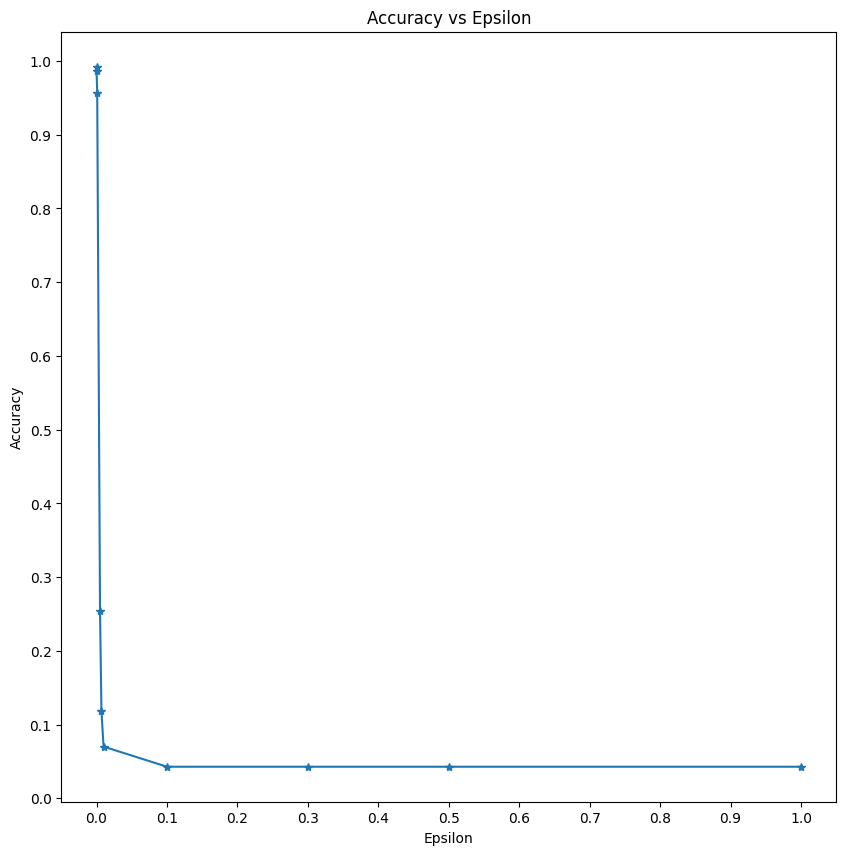

In [13]:
def plot_accuracy(epsilons, accuracies):
    plt.figure(figsize=(10,10))
    plt.plot(epsilons, accuracies, "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, 1.1, step=0.1))
    plt.title("Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()
    plt.savefig(accuracies_path)
    plt.close()

plot_accuracy(epsilons, accuracies)

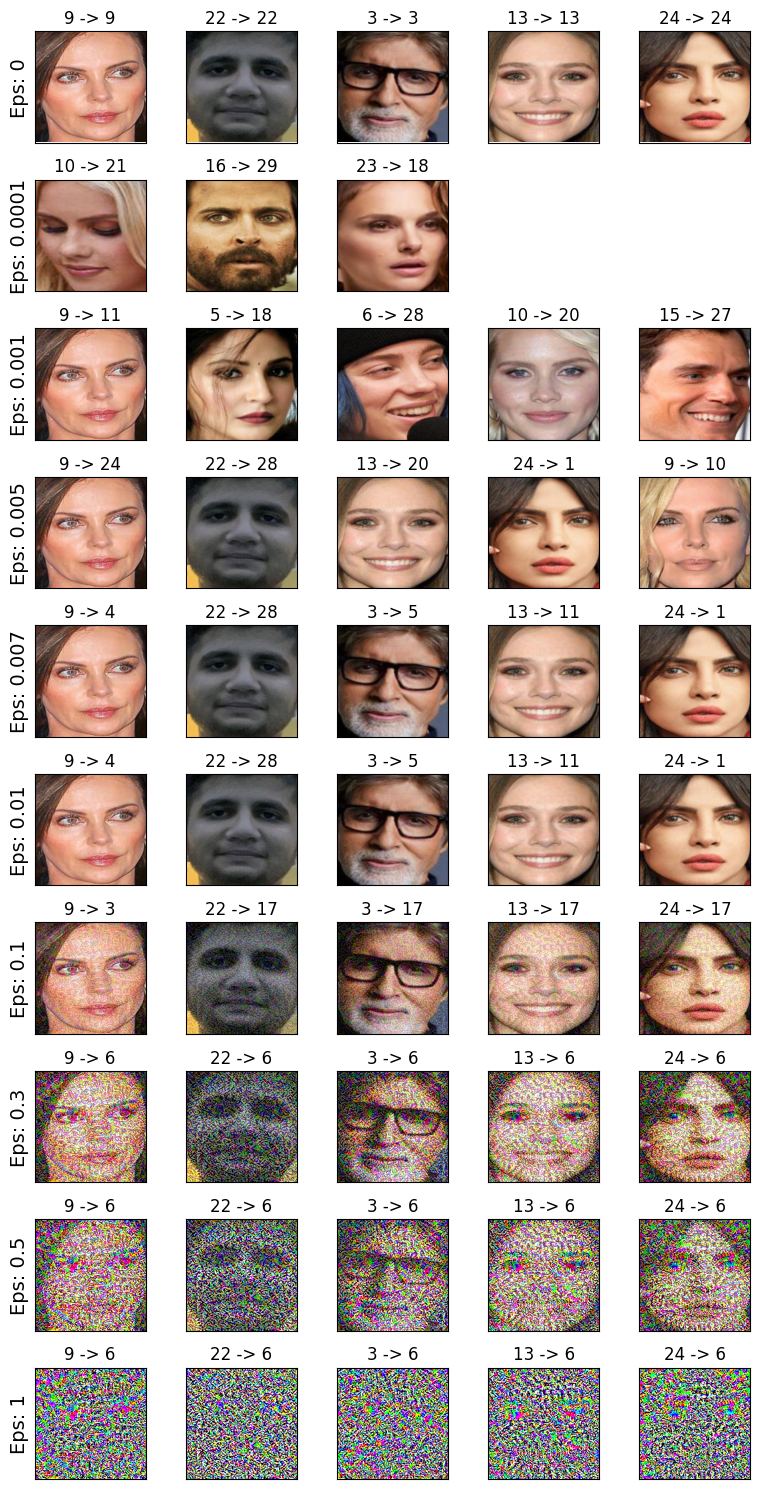

In [15]:
def plot_examples(examples, epsilons, max_examples=5, save_path=examples_path):
    """
    Plots a subset of adversarial examples for different epsilon values.

    Parameters:
    - examples: List of lists containing tuples (original_label, adversarial_label, adversarial_image).
    - epsilons: List of epsilon values corresponding to the adversarial examples.
    - max_examples: Maximum number of examples to display per epsilon. Default is 5.
    """
    cnt = 0
    plt.figure(figsize=(8, 15))

    for i in range(len(epsilons)):
        num_examples = len(examples[i])  # Number of available examples for this epsilon
        for j in range(max_examples):
            cnt += 1
            plt.subplot(len(epsilons), max_examples, cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
            
            # Check if there's an example to plot
            if j < num_examples:
                orig, adv, ex = examples[i][j]
                plt.title(f"{orig} -> {adv}")
                ex = np.clip(ex, 0, 1)  # Ensure the image data is in the range [0, 1]
                plt.imshow(ex.transpose(1, 2, 0))
            else:
                # Leave the space blank
                plt.title("")
                plt.imshow(np.ones((32, 32, 3)))  # Example blank image (white background)
                plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path)
    plt.close()

plot_examples(examples, epsilons, max_examples=5, save_path=examples_path)